In [1]:
import numpy as np
import skimage.io as io
from skimage.transform import resize, downscale_local_mean
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pycocotools.mask import decode, encode

import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, ZeroPadding2D, UpSampling2D, Add, Reshape, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.losses import categorical_crossentropy

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.vgg19 import VGG19

from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
# from keras.applications.xception import Xception
# from keras.applications.mobilenet_v2 import MobileNetV2

# import cv2

from pycocotools.cocostuffeval import *
from pycocotools.cocostuffhelper import *

Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

[]

# Data Preprocessing

In [2]:
annFile = 'annotations/stuff_val2017.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!


In [17]:
# 324158
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

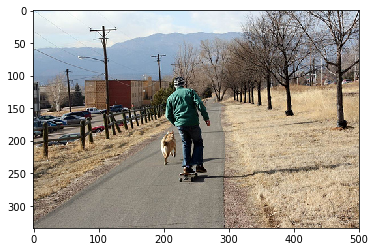

In [18]:
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.show()

C:\Anaconda2\envs\py36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


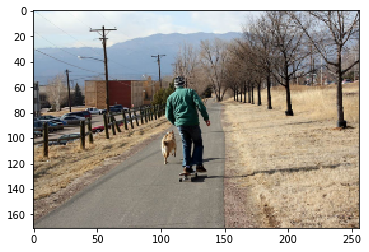

In [19]:
factor = max(I.shape[0], I.shape[1])/256
resized = resize(I, (int(I.shape[0] / factor), int(I.shape[1] / factor)),
                       anti_aliasing=True)
plt.imshow(resized)
plt.show()

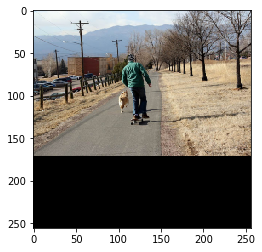

In [20]:
final_resized = np.zeros((256, 256, 3))
final_resized[:resized.shape[0], :resized.shape[1]] = resized
plt.imshow(final_resized)
plt.show()

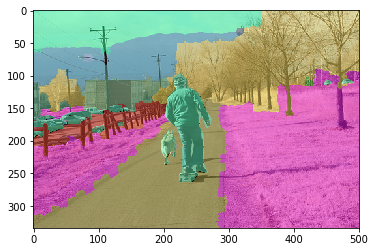

In [21]:
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [66]:
import cv2

gt = get_ground_truth(coco, 324158, num_classes=92, class_start_id=92)

reshaped_gt = np.zeros((256, 256, 92))
for i in range(92):
    reshaped_channel = cv2.resize(gt[:,:,i], (int(I.shape[0] / factor), int(I.shape[1] / factor)))
    reshaped_gt[:reshaped_channel.shape[0], :reshaped_channel.shape[1], i] = reshaped_channel
reshaped_gt = downscale_local_mean(gt, (int(I.shape[0]/256), int(I.shape[1]/256), 1), cval=0)
np.unique(reshaped_gt)

array([0., 1.])

In [7]:
# 0, 124, 169
single_stuff = np.zeros_like(labelMap)
single_stuff[labelMap == 124] = 255
conc = np.zeros((334, 500, 3))
conc[:, :, 0] = single_stuff
conc[:, :, 1] = single_stuff
conc[:, :, 2] = single_stuff
plt.imshow(conc)

NameError: name 'labelMap' is not defined

In [3]:
def get_ground_truth(coco, imgId, num_classes=92, class_start_id=92):
    label_map = cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True)
    ground_truth = np.zeros((label_map.shape[0], label_map.shape[1], num_classes))
    
    for i in range(num_classes):
        ground_truth[:, :, i][label_map == class_start_id + i] = 1
    return ground_truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


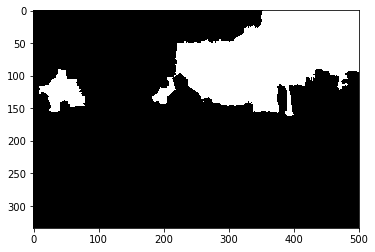

In [9]:
ground_truth = get_ground_truth(coco, 324158)
img = np.repeat(ground_truth[:, :, 77, np.newaxis], 3, axis=2)
img = img * 255
plt.imshow(img)

# Train model

In [75]:
def batch(coco, input_shape, n=32):
#     if mode == 'train':
#         annFile = 'annotations/stuff_train2017.json'
#     elif mode == 'val':
#         annFile = 'annotations/stuff_val2017.json'
#     coco = COCO(annFile)
    imgIds = coco.getImgIds()
    
    l = len(imgIds)
    
    for ndx in range(0, l, n):
        batch_ids = imgIds[ndx:min(ndx + n, l)]
        imgs_dict = coco.loadImgs(batch_ids)
        
        imgs = []
        y = []
        for img in imgs_dict:
            image = io.imread(img['coco_url'])            
            reshaped = np.zeros((input_shape[0], input_shape[1], 3))
            
            cropped_h = min(image.shape[0], input_shape[0])
            cropped_w = min(image.shape[1], input_shape[1])
            reshaped[:cropped_h, :cropped_w] = image[:cropped_h, :cropped_w]
            imgs.append(reshaped.tolist())
        
        for imgId in batch_ids:
            gt = get_ground_truth(coco, imgId, num_classes=92, class_start_id=92)
            reshaped_gt = np.zeros((input_shape[0], input_shape[1], gt.shape[2]))
            reshaped_gt[:cropped_h, :cropped_w] = gt[:cropped_h, :cropped_w]
            
            y.append(reshaped_gt.tolist())
        yield np.array(imgs), np.array(y) 

In [4]:
def batch(coco, input_shape, n=32):
#     if mode == 'train':
#         annFile = 'annotations/stuff_train2017.json'
#     elif mode == 'val':
#         annFile = 'annotations/stuff_val2017.json'
#     coco = COCO(annFile)
    imgIds = coco.getImgIds()

    l = len(imgIds)

    # with tf.device("/cpu:0"):
    for ndx in range(0, l, n):
        # print("Here1")
        batch_ids = imgIds[ndx:min(ndx + n, l)]
        imgs_dict = coco.loadImgs(batch_ids)

        imgs = []
        y = []

        for i in range(len(batch_ids)):
            img = imgs_dict[i]
            imgId = batch_ids[i]

            image = io.imread(img['coco_url'])
            # print(imgId, image.shape)
            if len(image.shape) != 3:
                image = np.asarray(np.dstack((image, image, image)), dtype=np.uint8)

            reshaped = np.zeros((input_shape[0], input_shape[1], 3))

            cropped_h = min(image.shape[0], input_shape[0])
            cropped_w = min(image.shape[1], input_shape[1])
            #print("Here1")
            reshaped[:cropped_h, :cropped_w] = image[:cropped_h, :cropped_w]
            #print("Here2")
            imgs.append(reshaped.tolist())

            gt = get_ground_truth(coco, imgId, num_classes=92, class_start_id=92)
            reshaped_gt = np.zeros((input_shape[0], input_shape[1], gt.shape[2]))
            #print(gt.shape, reshaped_gt.shape, cropped_h, cropped_w)
            #print("Here3")
            reshaped_gt[:cropped_h, :cropped_w] = gt[:cropped_h, :cropped_w]
            #print("Here4")

            y.append(reshaped_gt.tolist())
        # print("Here2")
        yield np.array(imgs), np.array(y)

In [ ]:
train_gen = batch('val')
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0])
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()
imgs, y = next(train_gen)
plt.imshow(imgs[0].astype('uint8'))
plt.show()

In [3]:
def gen_model():
    # input shape: (428, 640, 92)
    model = VGG19(include_top=False, input_shape=(428, 640, 3))    
    for layer in model.layers:
        layer.trainable = False
        
    skip_connection1 = model.layers[-2].output
    
    out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)  
    out = Add()([skip_connection1, out])
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    
    skip_connection2 = model.layers[5].output
    out = Add()([skip_connection2, out])
    out = BatchNormalization()(out)
       
    out = Conv2DTranspose(92, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    seg_model = Model(inputs=model.inputs, outputs=[out])   
    
    print(seg_model.summary())
    return seg_model
    
gen_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 428, 640, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 428, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 428, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 214, 320, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [4]:
def gen_model2():
    # input shape: (428, 640, 92)
    model = VGG19(include_top=False, input_shape=(428, 640, 3))    
    for layer in model.layers:
        layer.trainable = False
        
    for i in range(5):
        model.layers.pop()
        
#     skip_connection1 = model.layers[-2].output
    
#     out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)  
#     out = Add()([skip_connection1, out])
#     out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    out = ZeroPadding2D((1,0))(out)
    
    skip_connection2 = model.layers[5].output
    out = Add()([skip_connection2, out])
    out = BatchNormalization()(out)
       
    out = Conv2DTranspose(92, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    seg_model = Model(inputs=model.inputs, outputs=[out])   
    
    print(seg_model.summary())
    return seg_model
    
gen_model2()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 428, 640, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 428, 640, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 428, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 214, 320, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [4]:
def gen_model3():
    # input shape: (428, 640, 92)
    model = VGG19(include_top=False, input_shape=(128, 128, 3))    
    for layer in model.layers:
        layer.trainable = False
        
    for i in range(5):
        model.layers.pop()
        
#     skip_connection1 = model.layers[-2].output
    
#     out = Conv2DTranspose(512, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)  
#     out = Add()([skip_connection1, out])
#     out = BatchNormalization()(out)
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
#     out = ZeroPadding2D((1,0))(out)
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
#     out = ZeroPadding2D((1,0))(out)
    
    skip_connection2 = model.layers[5].output
    out = Add()([skip_connection2, out])
    out = BatchNormalization()(out)
       
    out = Conv2DTranspose(92, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    seg_model = Model(inputs=model.inputs, outputs=[out])   
    
    print(seg_model.summary())
    return seg_model
    
gen_model3()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [72]:
def gen_model4():
    # input shape: (428, 640, 92)
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))    
    model.add(MaxPooling2D())
    
    out = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(model.layers[-1].output)
    skip_connection = model.layers[-2].output
    out = Add()([skip_connection, out])
    out = BatchNormalization()(out)

    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)
    skip_connection2 = model.layers[-4].output
    out = Add()([skip_connection2, out])
    out = BatchNormalization()(out)
    
    out = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    skip_connection3 = model.layers[-6].output
    out = Add()([skip_connection3, out])
    out = BatchNormalization()(out)
       
    out = Conv2DTranspose(92, (3, 3), strides=(2, 2), activation='relu', padding='same')(out)    
    seg_model = Model(inputs=model.inputs, outputs=[out])   
    
    print(seg_model.summary())
    return seg_model
    
gen_model4()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 3584        conv2d_1_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 128 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 147584      max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [ ]:
y = np.array([get_ground_truth(coco, 324158, num_classes=92, class_start_id=92)])

In [5]:
def pixelwise_crossentropy(y_true, y_pred):
    reshaped_output = Reshape((-1, 92))(y_pred)
    new_output = Activation('softmax')(reshaped_output)
    return categorical_crossentropy(Reshape((-1, 92))(y_true), new_output)

In [29]:
# TODO: set steps_per_epoch, validation_steps
# def train_model(X, y):
def train_model():  
    model = gen_model()
#     model.compile('adam', 'mse', ['mae'])
    model.compile(loss=pixelwise_crossentropy, optimizer='adam')
    
    model_path = './model.h5'
    callbacks = [
    EarlyStopping(
        monitor='loss', 
        patience=10,
        mode='min',
        verbose=1),
    ModelCheckpoint(model_path,
        monitor='loss', 
        save_best_only=True, 
        mode='min',
        verbose=0)
    ]
#     history = model.fit(X, y, epochs=2, batch_size=32, validation_split=0.0, shuffle=True, callbacks=callbacks)
    
    train_file = 'annotations/stuff_val2017.json'
    coco_train = COCO(train_file)
    
    val_file = 'annotations/stuff_val2017.json'
    coco_val = COCO(val_file)

    training_generator = batch(coco_train, 1)
    validation_generator = batch(coco_val, 1)
    history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=2,
                    use_multiprocessing=False,
                    workers=1, 
                    shuffle=True,
                    steps_per_epoch=10,
                    validation_steps=10,
                    callbacks=callbacks)
    return model, history

In [ ]:
train_model()

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!
loading annotations into memory...
Done (t=193.50s)
creating index...
index created!
Epoch 1/2


In [ ]:
train_model(np.array([I]), y)

# Evaluation

In [22]:
def convert_pred_to_label_map(pred, class_start_id=92):
    print("Argmax: {}".format(np.unique(np.argmax(pred, axis=2))))
    return class_start_id + np.argmax(pred, axis=2)

In [ ]:
def evaluate(cocoGt):
    img = coco.loadImgs([324158])[0]
    I = io.imread(img['coco_url'])
    
    model = gen_model()    
    y = model.predict(np.array([I]))
    labelMap = convert_pred_to_label_map(y[0])
    
    anns = segmentationToCocoResult(labelMap, 324158, stuffStartId=92)   
    cocoRes = coco.loadRes(anns)
    coco_eval = COCOStuffeval(cocoGt, cocoRes)
    coco_eval.params.imgIds = [324158]
    coco_eval.evaluate()
    coco_eval.summarize()

In [ ]:
evaluate(coco)

In [79]:
def evaluate2(val_file):
    print("Evaluating...")

    cocoGt = COCO(val_file)
    intersection = 0

    model = gen_model4()
    validation_generator = batch(cocoGt, (256, 256, 3), 10)
    for images, gt in validation_generator:
        y = model.predict(images)

        for i in range(y.shape[0]):
            labelMap_pred = convert_pred_to_label_map(y[i])
            labelMap_gt = convert_pred_to_label_map(gt[i])

            intersection = intersection + len(labelMap_pred == labelMap_gt)

    iou = intersection / float(256 * 256 * len(cocoGt.getImgIds()))
    return iou

In [78]:
evaluate2(annFile)

Evaluating...
loading annotations into memory...
Done (t=2.72s)
creating index...
index created!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_13_input (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 128 3584        conv2d_13_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 128 147584      max_pooling2d_13[0][0]           
____________

7.8125e-06

In [90]:
def visualize_pred(val_file):
    model = load_model('./model.h5', custom_objects={'pixelwise_crossentropy': pixelwise_crossentropy})
    
    cocoGt = COCO(val_file)
    imgIds = cocoGt.getImgIds()
    
#     print("Img id: {}".format(imgIds[4]))
    validation_generator = batch(cocoGt, (256, 256, 3), 5)
    images, gt = next(validation_generator)
    
    img = cocoGt.loadImgs([imgIds[3]])[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I[:256, :256])
    plt.show()
    
#     images = [np.array(images.tolist()[0])]
    y = model.predict(images)
#     print(y.shape)
    labelMap_pred = convert_pred_to_label_map(y[3])    
    labels = np.unique(labelMap_pred)
    if labels[len(labels) - 1] == 183:
        labels = labels[:-1]
    
    cmap = get_cmap(len(labels))
    
    grid_3d = I[:256, :256, :]
    for i in range(len(labels)):
        label = labels[i]
        grid_3d[labelMap_pred == label] = np.array(cmap[i]).astype('uint8')
        
    plt.imshow(grid_3d)
    plt.show()
    
    print(np.unique(labelMap_pred))
    print(np.bincount(labelMap_pred.flatten()))
    
    grid = np.zeros_like(labelMap_pred).astype('uint8')
#     grid[labelMap_pred == np.argmax(np.bincount(labelMap_pred.flatten()))] = 255
    grid[labelMap_pred == 92] = 255
#     anns = segmentationToCocoResult(labelMap_pred, imgIds[0], stuffStartId=92)
# #     print(anns)
#     cocoRes = cocoGt.loadRes(anns)
#     cocoRes.showAnns(anns)
#     print(np.unique(grid))
    plt.imshow(grid, cmap='gray')
    plt.show()

C:\Anaconda2\envs\py36\lib\site-packages\keras\utils\conv_utils.py:82: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


loading annotations into memory...
Done (t=1.52s)
creating index...
index created!


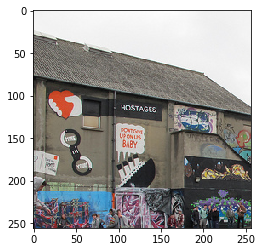

Argmax: [ 0 41 45 50 58 65 70 77 81 90 91]


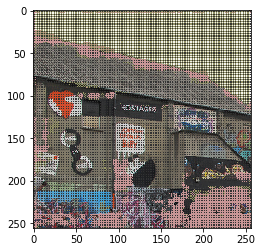

[ 92 133 137 142 150 157 162 169 173 182 183]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 16369     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     2     0     0     0     1     0     0     0     0     3     0
     0     0     0     0     0     0    26     0     0     0     0     0
     

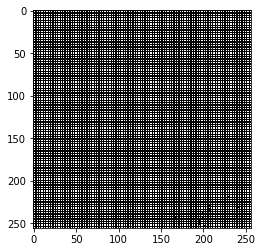

In [91]:
from keras.models import load_model
visualize_pred(annFile)

In [76]:
from copy import copy

def get_cmap(size):
    incr_index = 0
    incr = 50
    
    cmap = [[50,50,50]]
    for i in range(size - 1):
        last = cmap[len(cmap) - 1]
        last_copy = copy(last)
        last_copy[incr_index] = last_copy[incr_index] + incr
        cmap.append(last_copy)
        incr_index = (incr_index + 1) % 3
        
    return cmap